In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

# 1. Data Pre-processing

## 1.0 Load dataset

In [3]:
df_train = pd.read_csv('dataset/train_ziji_mar27.csv')

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25718 entries, 0 to 25717
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   listing_id      25718 non-null  int64  
 1   name            25718 non-null  object 
 2   street          25718 non-null  object 
 3   type            25718 non-null  object 
 4   bathrooms       24484 non-null  float64
 5   district        25718 non-null  int64  
 6   region          25718 non-null  object 
 7   planning_area   25718 non-null  object 
 8   subszone        25718 non-null  object 
 9   built_year      25645 non-null  float64
 10  no_of_units     24680 non-null  float64
 11  area_size       25718 non-null  float64
 12  date_listed     25718 non-null  object 
 13  price           25718 non-null  float64
 14  bedrooms        25718 non-null  float64
 15  tenure_remains  25718 non-null  int64  
 16  tenure_years    25718 non-null  int64  
dtypes: float64(6), int64(4), object

In [5]:
df_train.head()

,listing_id,name,street,type,bathrooms,district,region,planning_area,subszone,built_year,no_of_units,area_size,date_listed,price,bedrooms,tenure_remains,tenure_years
0,6998418,seascape,57 cove way,condominium,4.0,4,central region,southern islands,sentosa,2011.0,151.0,2336.0,2021-05-04,5390000.0,3.0,99,99
1,2046604,la maison,10 moulmein rise,apartment,3.0,11,central region,novena,moulmein,1999.0,24.0,1259.0,2021-05-07,2310000.0,3.0,1000000,999
2,7563513,viva,2 suffolk walk,condominium,3.0,11,central region,novena,moulmein,2012.0,235.0,1959.0,2021-06-30,5279500.0,4.0,1000000,999
3,3071445,urban treasures,205 jalan eunos,condominium,2.0,14,east region,bedok,kaki bukit,1930.0,237.0,883.0,2022-01-02,1843600.0,3.0,1000000,999
4,9667539,infini at east coast,east coast road,apartment,3.0,15,east region,bedok,frankel,2022.0,36.0,1066.0,2021-12-24,2262700.0,3.0,1000000,999


In [7]:
df_train.describe()

,listing_id,bathrooms,district,built_year,no_of_units,area_size,price,bedrooms,tenure_remains,tenure_years
count,2.571800e+04,24484.000000,25718.000000,25645.000000,24680.000000,25718.000000,2.571800e+04,25718.000000,25718.000000,25718.000000
mean,5.495814e+06,2.281000,12.212497,1995.159524,461.681483,1251.166343,3.003332e+06,2.566879,380276.113889,456.263395
std,2.607456e+06,1.146691,7.011785,33.875646,423.024212,1067.453284,4.340523e+06,1.143536,485386.342802,440.349250
min,1.000122e+06,1.000000,1.000000,1910.000000,4.000000,323.000000,5.566000e+05,0.000000,0.000000,99.000000
25%,3.227969e+06,1.000000,7.000000,1985.000000,130.000000,689.000000,1.342000e+06,2.000000,99.000000,99.000000
50%,5.489918e+06,2.000000,11.000000,2013.000000,366.000000,958.000000,1.856800e+06,3.000000,99.000000,99.000000
75%,7.764957e+06,3.000000,18.000000,2017.000000,646.000000,1363.750000,2.956800e+06,3.000000,1000000.000000,999.000000
max,9.999807e+06,8.000000,28.000000,2029.000000,2203.000000,15000.000000,7.480000e+07,8.000000,1000000.000000,999.000000


###  (optional) drop meaningless attributes

In [6]:
meaningless_attrs = ['tenure_remains', 'listing_id', 'date_listed']
# meaningless_attrs = ['tenure_remains', 'date_listed', 'street', 'listing_id']

df_train_small = df_train.drop(labels=meaningless_attrs, axis=1)

In [7]:
df_train_small.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25718 entries, 0 to 25717
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           25718 non-null  object 
 1   street         25718 non-null  object 
 2   type           25718 non-null  object 
 3   bathrooms      24484 non-null  float64
 4   district       25718 non-null  int64  
 5   region         25718 non-null  object 
 6   planning_area  25718 non-null  object 
 7   subszone       25718 non-null  object 
 8   built_year     25645 non-null  float64
 9   no_of_units    24680 non-null  float64
 10  area_size      25718 non-null  float64
 11  price          25718 non-null  float64
 12  bedrooms       25718 non-null  float64
 13  tenure_years   25718 non-null  int64  
dtypes: float64(6), int64(2), object(6)
memory usage: 2.7+ MB


## 1.1 Label encoding

There are multiple ways to encode the categorical values.

We explore:
 a) ordered encoding
 b) one-hot encoding
 c) combination of a) and b)

In [10]:
df_train_small.dtypes

name              object
street            object
type              object
bathrooms        float64
district           int64
region            object
planning_area     object
subszone          object
built_year       float64
no_of_units      float64
area_size        float64
price            float64
bedrooms         float64
tenure_years       int64
dtype: object

In [11]:
# df_train_small.date_listed = pd.to_datetime(df_train_small.date_listed)

In [11]:
df_train_small.head()

,name,street,type,bathrooms,district,region,planning_area,subszone,built_year,no_of_units,area_size,price,bedrooms,tenure_years
0,seascape,57 cove way,condominium,4.0,4,central region,southern islands,sentosa,2011.0,151.0,2336.0,5390000.0,3.0,99
1,la maison,10 moulmein rise,apartment,3.0,11,central region,novena,moulmein,1999.0,24.0,1259.0,2310000.0,3.0,999
2,viva,2 suffolk walk,condominium,3.0,11,central region,novena,moulmein,2012.0,235.0,1959.0,5279500.0,4.0,999
3,urban treasures,205 jalan eunos,condominium,2.0,14,east region,bedok,kaki bukit,1930.0,237.0,883.0,1843600.0,3.0,999
4,infini at east coast,east coast road,apartment,3.0,15,east region,bedok,frankel,2022.0,36.0,1066.0,2262700.0,3.0,999


In [12]:
df_train_small.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25718 entries, 0 to 25717
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           25718 non-null  object 
 1   street         25718 non-null  object 
 2   type           25718 non-null  object 
 3   bathrooms      24484 non-null  float64
 4   district       25718 non-null  int64  
 5   region         25718 non-null  object 
 6   planning_area  25718 non-null  object 
 7   subszone       25718 non-null  object 
 8   built_year     25645 non-null  float64
 9   no_of_units    24680 non-null  float64
 10  area_size      25718 non-null  float64
 11  price          25718 non-null  float64
 12  bedrooms       25718 non-null  float64
 13  tenure_years   25718 non-null  int64  
dtypes: float64(6), int64(2), object(6)
memory usage: 2.7+ MB


In [8]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
df_train_ord = df_train_small.copy()

### 1.1.A. Ordinal encoding

In [9]:
ord_enc = OrdinalEncoder()

cat_cols = ['name', 'type', 'region', 'planning_area', 'subszone']
for cate in cat_cols:
    df_train_ord[f"{cate}_code"] = ord_enc.fit_transform(df_train_ord[[cate]])
df_train_ord.head(11)

,name,street,type,bathrooms,district,region,planning_area,subszone,built_year,no_of_units,area_size,price,bedrooms,tenure_years,name_code,type_code,region_code,planning_area_code,subszone_code
0,seascape,57 cove way,condominium,4.0,4,central region,southern islands,sentosa,2011.0,151.0,2336.0,5390000.0,3.0,99,1059.0,1.0,0.0,32.0,147.0
1,la maison,10 moulmein rise,apartment,3.0,11,central region,novena,moulmein,1999.0,24.0,1259.0,2310000.0,3.0,999,617.0,0.0,0.0,20.0,108.0
2,viva,2 suffolk walk,condominium,3.0,11,central region,novena,moulmein,2012.0,235.0,1959.0,5279500.0,4.0,999,1582.0,1.0,0.0,20.0,108.0
3,urban treasures,205 jalan eunos,condominium,2.0,14,east region,bedok,kaki bukit,1930.0,237.0,883.0,1843600.0,3.0,999,1550.0,1.0,1.0,1.0,76.0
4,infini at east coast,east coast road,apartment,3.0,15,east region,bedok,frankel,2022.0,36.0,1066.0,2262700.0,3.0,999,530.0,0.0,1.0,1.0,56.0
5,the watergardens at canberra,canberra drive,apartment,1.0,27,north region,sembawang,sembawang springs,1930.0,448.0,678.0,1131900.0,2.0,99,1480.0,0.0,2.0,28.0,143.0
6,midwood,hillview rise,condominium,3.0,23,west region,bukit batok,hillview,1930.0,564.0,1249.0,2189000.0,4.0,99,736.0,1.0,4.0,3.0,62.0
7,sengkang grand residences,compassvale bow,apartment,2.0,19,north-east region,sengkang,compassvale,2023.0,680.0,936.0,1595000.0,3.0,99,1068.0,0.0,3.0,29.0,41.0
8,midtown bay,122 beach road,apartment,1.0,7,central region,downtown core,city hall,2021.0,219.0,409.0,1490500.0,1.0,99,733.0,0.0,0.0,10.0,36.0
9,76 shenton,76 shenton way,apartment,1.0,2,central region,downtown core,anson,2014.0,202.0,592.0,1265000.0,1.0,99,26.0,0.0,0.0,10.0,5.0


Drop original columns

In [10]:
df_train_ord = df_train_ord.drop(columns=cat_cols, axis=1)
df_train_ord = df_train_ord.drop(columns='street', axis=1)

In [11]:
df_train_ord.head()

,bathrooms,district,built_year,no_of_units,area_size,price,bedrooms,tenure_years,name_code,type_code,region_code,planning_area_code,subszone_code
0,4.0,4,2011.0,151.0,2336.0,5390000.0,3.0,99,1059.0,1.0,0.0,32.0,147.0
1,3.0,11,1999.0,24.0,1259.0,2310000.0,3.0,999,617.0,0.0,0.0,20.0,108.0
2,3.0,11,2012.0,235.0,1959.0,5279500.0,4.0,999,1582.0,1.0,0.0,20.0,108.0
3,2.0,14,1930.0,237.0,883.0,1843600.0,3.0,999,1550.0,1.0,1.0,1.0,76.0
4,3.0,15,2022.0,36.0,1066.0,2262700.0,3.0,999,530.0,0.0,1.0,1.0,56.0


In [14]:
# for cate in cat_cols:
#     df_train_small[cate] = df_train_small[cate].astype('category')
# df_train_small.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25722 entries, 0 to 25721
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   name           25722 non-null  category      
 1   type           25722 non-null  category      
 2   bedrooms       25325 non-null  category      
 3   bathrooms      24488 non-null  float64       
 4   district       25722 non-null  int64         
 5   region         25722 non-null  category      
 6   planning_area  25722 non-null  category      
 7   subszone       25722 non-null  category      
 8   tenure         25437 non-null  category      
 9   built_year     25649 non-null  float64       
 10  no_of_units    24684 non-null  float64       
 11  area_size      25722 non-null  float64       
 12  date_listed    25722 non-null  datetime64[ns]
 13  price          25722 non-null  float64       
dtypes: category(7), datetime64[ns](1), float64(5), int64(1)
memory usage: 

### Check the value of encoded categorical attributes

In [15]:
df_train_small["planning_area_cat"] = df_train_small["planning_area"].cat.codes
df_train_small.head()

,name,type,bedrooms,bathrooms,district,region,planning_area,subszone,tenure,built_year,no_of_units,area_size,date_listed,price,planning_area_cat
0,seascape,condominium,3,4.0,4,central region,southern islands,sentosa,leasehold/99 years,2011.0,151.0,2336.0,2021-05-04,5390000.0,32
1,la maison,apartment,3,3.0,11,central region,novena,moulmein,freehold,1999.0,24.0,1259.0,2021-05-07,2310000.0,20
2,viva,condominium,4,3.0,11,central region,novena,moulmein,freehold,2012.0,235.0,1959.0,2021-06-30,5279500.0,20
3,urban treasures,condominium,3,2.0,14,east region,bedok,kaki bukit,freehold,1930.0,237.0,883.0,2022-01-02,1843600.0,1
4,infini at east coast,apartment,3,3.0,15,east region,bedok,frankel,freehold,2022.0,36.0,1066.0,2021-12-24,2262700.0,1


In [16]:
df_train_small = df_train_small.drop("planning_area_cat", axis=1)


In [47]:
df_train_small[df_train_small.built_year>2021].price.count

<bound method Series.count of 4        2262700.0
7        1595000.0
22       3480400.0
78       2651000.0
79       1234200.0
           ...    
25663    1552100.0
25684    2025100.0
25693    2653200.0
25707    1811700.0
25714    1151700.0
Name: price, Length: 2339, dtype: float64>

### 1.1.C Combine ordered and one-hot

In [37]:
from sklearn.compose import ColumnTransformer

In [44]:
# one-hot encode the categorical features

full_pipeline = ColumnTransformer([('cat', OrdinalEncoder(handle_unknown=''), cat_cols)],
                                  remainder='passthrough')

encoder = full_pipeline.fit(train_X)
train_X_cleaned = encoder.transform(train_X)
# X_test = encoder.transform(X_test)

ValueError: handle_unknown should be either 'error' or 'use_encoded_value', got .

In [59]:
oh_encoder = OneHotEncoder()
oh_encoder.fit(train_X)
train_X_cleaned = oh_encoder.transform(train_X).toarray()
oh_encoder.categories_

[array(['10 evelyn', '10 shelford', '111 emerald hill', ..., 'zedge',
        'zenith', 'zyanya'], dtype=object),
 array(['apartment', 'condominium'], dtype=object),
 array(['1', '1+1', '2', '2+1', '2+2', '3', '3+1', '3+2', '4', '4+1',
        '4+2', '5', '5+1', '6', '7', '8', '9', nan], dtype=object),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8., 10., nan]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 25, 26, 27, 28]),
 array(['central region', 'east region', 'north region',
        'north-east region', 'west region'], dtype=object),
 array(['ang mo kio', 'bedok', 'bishan', 'bukit batok', 'bukit merah',
        'bukit panjang', 'bukit timah', 'changi', 'choa chu kang',
        'clementi', 'downtown core', 'geylang', 'hougang', 'jurong east',
        'jurong west', 'kallang', 'mandai', 'marine parade', 'museum',
        'newton', 'novena', 'orchard', 'outram', 'pasir ris', 'punggol',
        'queenstown', 'river valley',

In [60]:
train_X_cleaned.shape

(25722, 4134)

## 1.2 Normalization

# 2. XGBoost Model Training

In [12]:
train_data = df_train_ord.copy()
# train_data = df_train_small.copy()
# train_data = df_train.copy()

In [13]:
train_X = train_data.loc[:, train_data.columns != "price"]
train_y = train_data.loc[:, train_data.columns == "price"]

In [14]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25718 entries, 0 to 25717
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bathrooms           24484 non-null  float64
 1   district            25718 non-null  int64  
 2   built_year          25645 non-null  float64
 3   no_of_units         24680 non-null  float64
 4   area_size           25718 non-null  float64
 5   price               25718 non-null  float64
 6   bedrooms            25718 non-null  float64
 7   tenure_years        25718 non-null  int64  
 8   name_code           25718 non-null  float64
 9   type_code           25718 non-null  float64
 10  region_code         25718 non-null  float64
 11  planning_area_code  25718 non-null  float64
 12  subszone_code       25718 non-null  float64
dtypes: float64(11), int64(2)
memory usage: 2.6 MB


In [15]:
train_X.head()

,bathrooms,district,built_year,no_of_units,area_size,bedrooms,tenure_years,name_code,type_code,region_code,planning_area_code,subszone_code
0,4.0,4,2011.0,151.0,2336.0,3.0,99,1059.0,1.0,0.0,32.0,147.0
1,3.0,11,1999.0,24.0,1259.0,3.0,999,617.0,0.0,0.0,20.0,108.0
2,3.0,11,2012.0,235.0,1959.0,4.0,999,1582.0,1.0,0.0,20.0,108.0
3,2.0,14,1930.0,237.0,883.0,3.0,999,1550.0,1.0,1.0,1.0,76.0
4,3.0,15,2022.0,36.0,1066.0,3.0,999,530.0,0.0,1.0,1.0,56.0


In [16]:
train_y.head()

,price
0,5390000.0
1,2310000.0
2,5279500.0
3,1843600.0
4,2262700.0


Use XGBoost's optimized data structure

In [17]:
# train_X = train_X.drop('date_listed', axis=1)
data_dmatrix = xgb.DMatrix(data=train_X,label=train_y)

## 2.1 Split cross-validation set

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.2, random_state=42)

## 2.2 Train XGBoost Regressor

In [21]:
xg_reg = xgb.XGBRegressor(eval_metric='rmse',
                          seed=42,
                          colsample_bytree = 0.3,
                          learning_rate = 0.1,
                          n_jobs=2,
                          max_depth = 5,
                          alpha = 10,
                          n_estimators = 10)

In [22]:
xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)

## 2.3 Training evaluation

In [23]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 2843990.320541


In [26]:
params = {'eval_metric':'rmse','colsample_bytree': 0.3,'learning_rate': 0.01,
                'max_depth': 10, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=10,
                    num_boost_round=50,early_stopping_rounds=15,
                    metrics="rmse", as_pandas=True, seed=42)

[15:45:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 392 extra nodes, 0 pruned nodes, max_depth=10
[15:45:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 466 extra nodes, 0 pruned nodes, max_depth=10
[15:45:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 442 extra nodes, 0 pruned nodes, max_depth=10
[15:45:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 468 extra nodes, 0 pruned nodes, max_depth=10
[15:45:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 426 extra nodes, 0 pruned nodes, max_depth=10
[15:45:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 438 extra nodes, 0 pruned nodes, max_depth=10
[15:45:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 446 extra nodes, 0 pruned nodes, max_depth=10
[15:45:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 452 extra nodes, 0 pruned nodes, max_depth=10
[15:45:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 456 extra nodes, 0 p

In [27]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,5239625.65,41602.578670,5227634.45,371436.093927
1,5201017.50,45941.937293,5189150.75,365595.661998
2,5167415.00,47119.062251,5155854.60,364220.366659
3,5130773.35,47257.761157,5119331.50,363169.979630
4,5094554.70,48260.636739,5084149.40,361725.549773


In [28]:
print((cv_results["test-rmse-mean"]).tail(1))

49    3781860.425
Name: test-rmse-mean, dtype: float64


## 2.4 Gridsearch for the best hyper-params

In [30]:
from sklearn.model_selection import GridSearchCV
import datetime

now = datetime.datetime.now()


In [31]:
# Various hyper-parameters to tune
gbt_reg = xgb.XGBRegressor(eval_metric='rmse', seed=42,)
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'learning_rate': [.03, 0.05, .07, 0.15, 0.3, 0.6], #so called `eta` value
              'max_depth': [5, 7, 9, 11],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.5], # Subsample ratio of the training instances. Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees. and this will prevent overfitting.
              'colsample_bytree': [0.7],
              'n_estimators': [i for i in range(10, 100, 10)]}

xgb_grid = GridSearchCV(gbt_reg,
                        parameters,
                        cv = 5,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(train_X,train_y)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
0.9607320716557244
{'colsample_bytree': 0.7, 'learning_rate': 0.15, 'max_depth': 9, 'min_child_weight': 4, 'n_estimators': 90, 'nthread': 4, 'silent': 1, 'subsample': 0.5}


In [32]:
print(now)
print(datetime.datetime.now())

2022-03-27 15:57:04.047510
2022-03-27 16:05:33.409276


## 2.5 Save trained model using pickle

In [33]:
best_reg = xgb.train(params=xgb_grid.best_params_, dtrain=data_dmatrix)


Save the model object in pickle format

In [39]:
import pickle

with open('model/xgb_tree/xgb_mar27.pickle', 'wb') as handle:
    pickle.dump(best_reg, handle, protocol=pickle.HIGHEST_PROTOCOL)

Load the pickle object

In [40]:
with open('model/xgb_tree/xgb_mar27.pickle', 'rb') as handle:
    b = pickle.load(handle)

print(best_reg == b)

False


## 2.6 Visualize learned decision tree

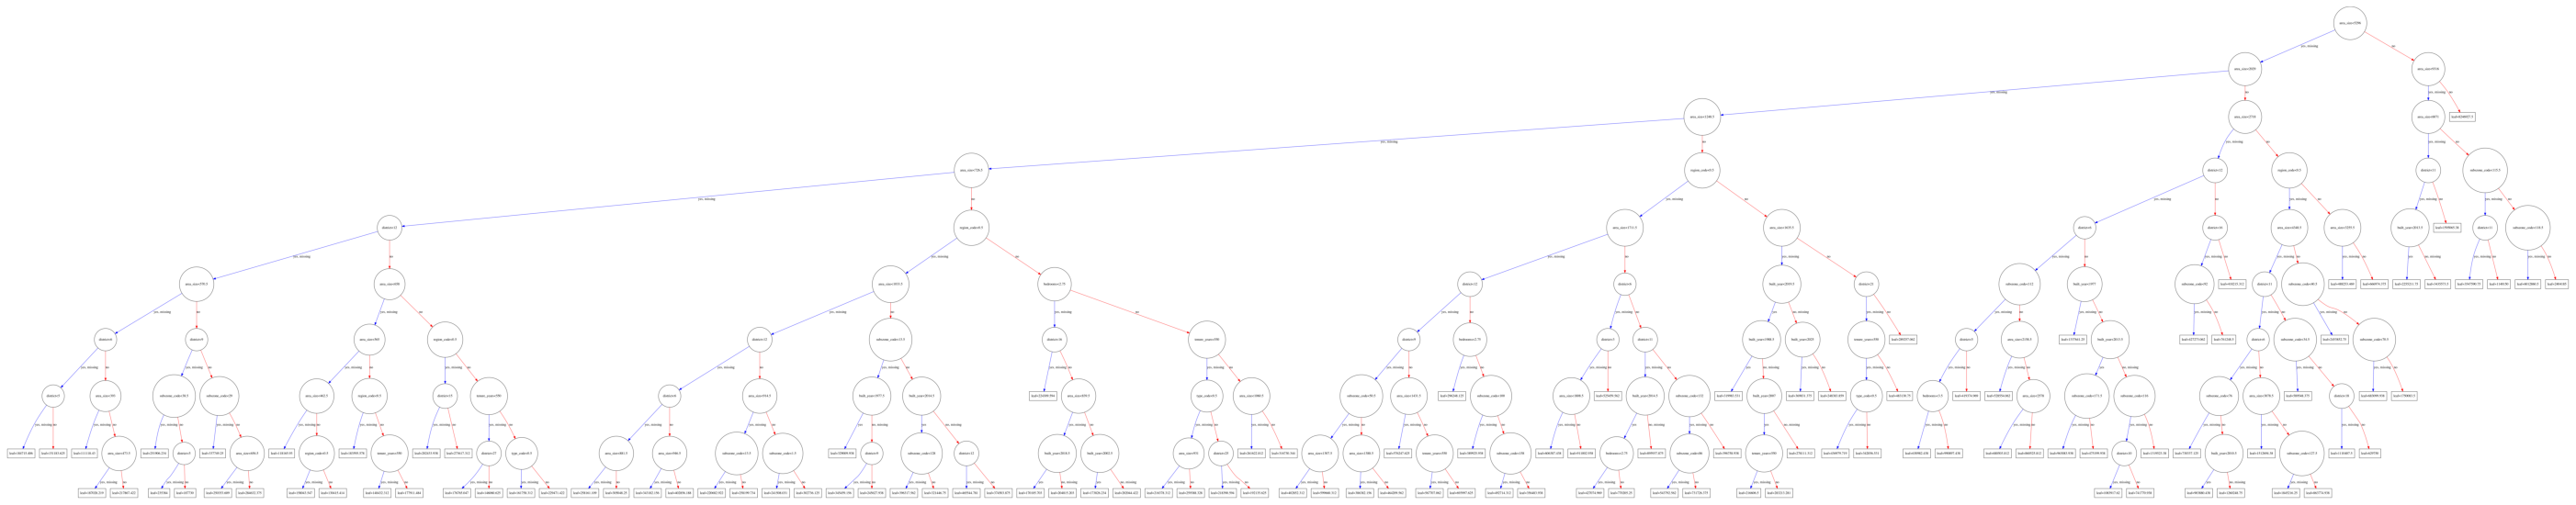

In [41]:
import matplotlib.pyplot as plt

xgb.plot_tree(best_reg,num_trees=0)
# plt.rcParams['figure.figsize'] = [50, 10]
# plt.plot()
plt.savefig('plots/xgb_tree/tree_vis.pdf', format='pdf', dpi=1200)

### Plot the importance of features

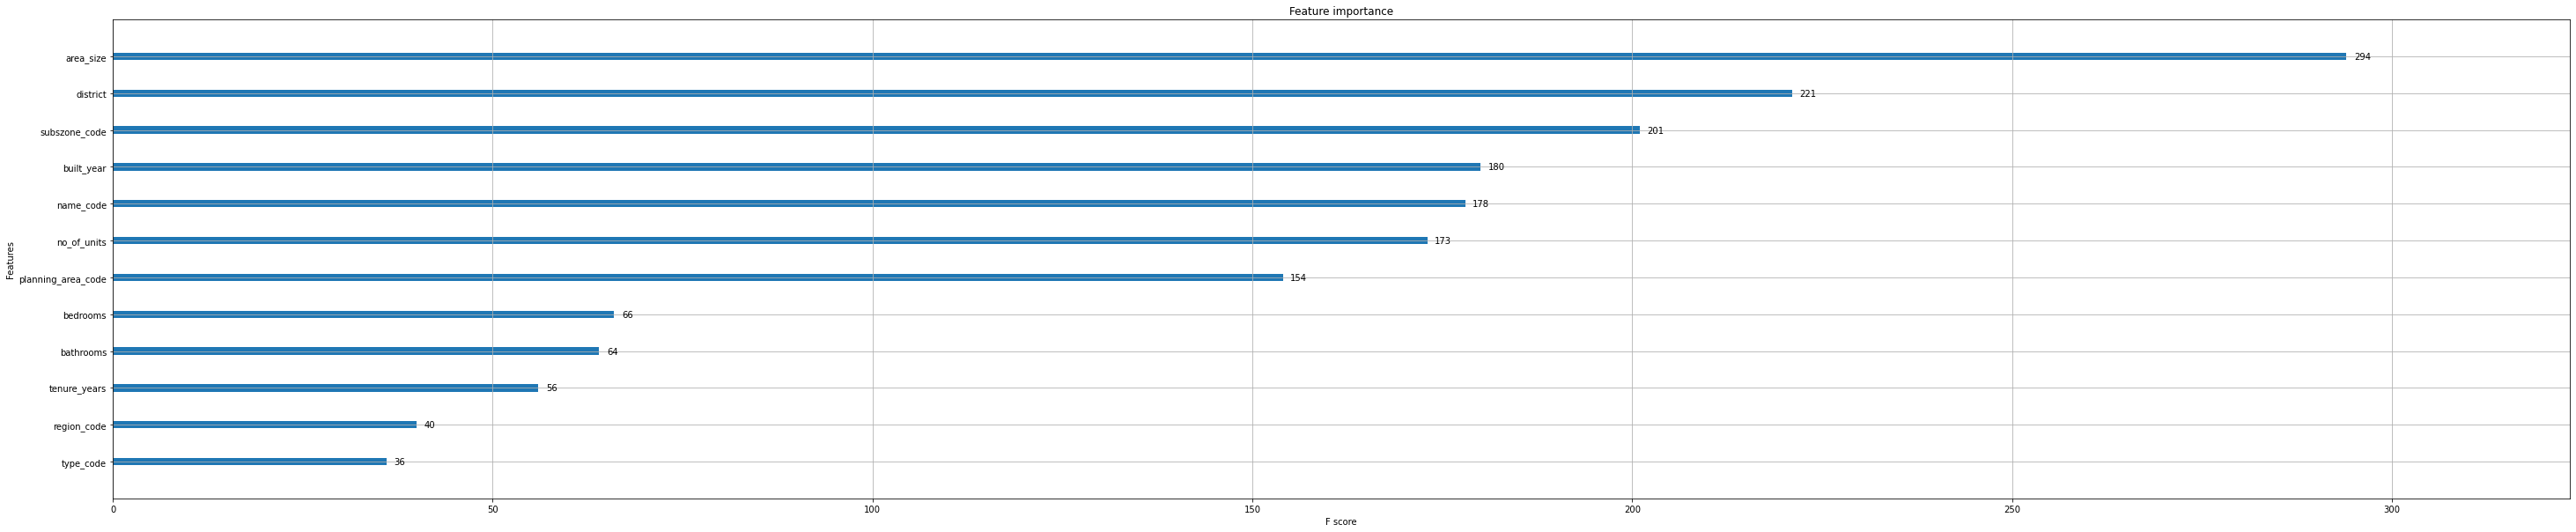

In [42]:
xgb.plot_importance(best_reg)
# plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

# 3. XGBoost Model Inference